In [1]:
import pandas as pd
import numpy as np

import re
import nltk
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import TweetTokenizer
from collections import defaultdict 

In [3]:
dataset_path = 'sentiment_analysis.csv'
df = pd.read_csv(dataset_path, index_col="id")

In [5]:
df.head()

,label,tweet
id,,
1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
2,0,Finally a transparant silicon case ^^ Thanks t...
3,0,We love this! Would you go? #talk #makememorie...
4,0,I'm wired I know I'm George I was made that wa...
5,1,What amazing service! Apple won't even talk to...


In [6]:
# Tiền xử lí dữ liệu
# Hàm chuẩn hóa dữ liệu văn bản
def text_normalize(text):
    # Loại bỏ từ "RT" (retweet) ở đầu
    text = re.sub(r'^RT[\s]+', '', text)
    
    # Loại bỏ các đường dẫn
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Loại bỏ ký tự hashtag
    text = re.sub(r'#', '', text)
    
    # Loại bỏ dấu câu
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenization
    tokenizer = TweetTokenizer(
        preserve_case=False,
        strip_handles=True,
        reduce_len=True
    )
    text_tokens = tokenizer.tokenize(text)
    
    return text_tokens

In [7]:

# Bộ lưu trữ tần suất xuất hiện của các từ
def get_freqs(df):
    # Khởi tạo dictionary với giá trị mặc định là 0
    freqs = defaultdict(lambda: 0)
    
    # Duyệt qua từng dòng trong DataFrame
    for idx, row in df.iterrows():
        tweet = row['tweet']
        label = row['label']
        
        # Chuẩn hóa và tách từ trong tweet
        tokens = text_normalize(tweet)
        
        # Đếm tần suất xuất hiện của mỗi từ và nhãn
        for token in tokens:
            pair = (token, label)
            freqs[pair] += 1
    
    return freqs

In [10]:

# Hàm tạo vecto đặc trưng
def get_feature(text, freqs):
    # Chuẩn hóa văn bản và tách từ
    tokens = text_normalize(text)
    
    # Khởi tạo vector đặc trưng với kích thước 3, trong đó X[0] = 1 (bias term)
    X = np.zeros(3)
    X[0] = 1  # Bias term
    
    # Tính tổng tần suất của token cho các nhãn 0 và 1
    for token in tokens:
        X[1] += freqs[(token, 0)]  # Tần suất của token với nhãn 0
        X[2] += freqs[(token, 1)]  # Tần suất của token với nhãn 1
    
    return X

In [11]:
# trích xuất đặc trưng toàn bộ dữ liệu
X = []
y = []

freqs = get_freqs(df)
for idx, row in df.iterrows():
    tweet = row['tweet']
    label = row['label']
    
    X_i = get_feature(tweet, freqs)
    
    X.append(X_i)
    y.append(label)

X = np.array(X)
y = np.array(y)

In [12]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [13]:
normalizer = StandardScaler()
X_train[: , 1:] = normalizer.fit_transform(X_train[:,1:])
X_val[: , 1:] = normalizer.transform(X_val[:,1:])
X_test[: , 1:] = normalizer.transform(X_test[: , 1:])

In [14]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(y_hat, y):
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)
    return (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()

def predict(X, theta):
    dot_product = np.dot(X, theta)
    y_hat = sigmoid(dot_product)
    return y_hat

def compute_gradient(X, y, y_hat):
    return np.dot(X.T, (y_hat - y)) / y.size

def update_theta(theta, gradient, lr):
    return theta - lr * gradient

def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta).round()
    acc = (y_hat == y).mean()
    return acc


In [18]:
lr = 0.01
epochs = 500
batch_size = 128

np.random.seed(random_state)
theta = np.random.uniform(
                        size = X_train.shape[1]
                        )

In [19]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i + batch_size]
        y_i = y_train[i:i + batch_size]

        y_hat = predict(X_i, theta)

        train_loss = compute_loss(y_i,y_hat)

        gradient = compute_gradient(X_i, y_i, y_hat)

        theta = update_theta(theta, gradient, lr)

        train_batch_losses.append(train_loss)

        train_acc = compute_accuracy(X_train, y_train, theta)
        train_batch_accs.append(train_acc)

        y_val_hat = predict(X_val, theta)
        val_loss = compute_loss(y_val, y_val_hat)
        val_batch_losses.append(val_loss)

        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)

    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

    train_losses.append(train_batch_loss)
    val_losses.append(val_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}')



EPOCH 1:	Training loss: 7.810	Validation loss: 7.769

EPOCH 2:	Training loss: 7.484	Validation loss: 7.446

EPOCH 3:	Training loss: 7.194	Validation loss: 7.158

EPOCH 4:	Training loss: 6.938	Validation loss: 6.904

EPOCH 5:	Training loss: 6.711	Validation loss: 6.679

EPOCH 6:	Training loss: 6.510	Validation loss: 6.481

EPOCH 7:	Training loss: 6.333	Validation loss: 6.305

EPOCH 8:	Training loss: 6.175	Validation loss: 6.149

EPOCH 9:	Training loss: 6.034	Validation loss: 6.010

EPOCH 10:	Training loss: 5.908	Validation loss: 5.885

EPOCH 11:	Training loss: 5.796	Validation loss: 5.774

EPOCH 12:	Training loss: 5.694	Validation loss: 5.673

EPOCH 13:	Training loss: 5.602	Validation loss: 5.583

EPOCH 14:	Training loss: 5.519	Validation loss: 5.500

EPOCH 15:	Training loss: 5.443	Validation loss: 5.425

EPOCH 16:	Training loss: 5.373	Validation loss: 5.356

EPOCH 17:	Training loss: 5.309	Validation loss: 5.293

EPOCH 18:	Training loss: 5.251	Validation loss: 5.236

EPOCH 19:	Training

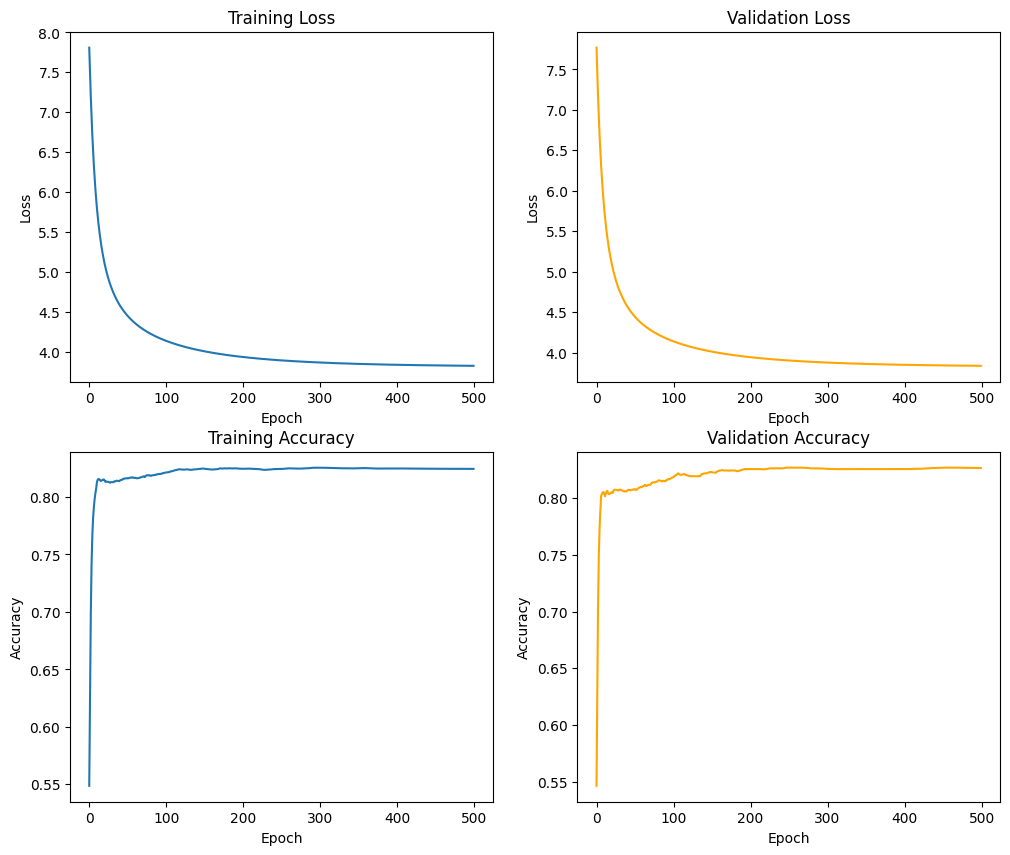

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Training Loss
ax[0, 0].plot(train_losses)
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].set_title('Training Loss')

# Validation Loss
ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('Loss')
ax[0, 1].set_title('Validation Loss')

# Training Accuracy
ax[1, 0].plot(train_accs)
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Validation Accuracy
ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()


In [21]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)

print('Evaluation on validation and test set:')
print(f'Validation Set Accuracy: {val_set_acc}')
print(f'Test Set Accuracy: {test_set_acc}')


Evaluation on validation and test set:
Validation Set Accuracy: 0.8263888888888888
Test Set Accuracy: 0.8409090909090909


In [22]:
X = np.array([[22.3, -1.5, 1.1, 1]])
theta = np.array([0.1, -0.15, 0.3, -0.2])

print(predict(X,theta))

[0.92988994]


In [23]:
y = np.array([1, 0, 0, 1])
y_hat = np.array([0.8, 0.75, 0.3,0.95])
print(compute_loss(y_hat,y))

0.5043515376900958


In [25]:
X = np.array([[1, 3], [2, 1], [3, 2], [1, 2]])
y_true = np.array([1, 0, 1, 1]) 
y_pred = np.array([0.7, 0.4, 0.6, 0.85])
print(compute_gradient(X, y_true, y_pred))

[-0.2125 -0.4   ]
